In [1]:
# Import netket library
import netket as nk
from qiskit.chemistry import FermionicOperator
import itertools

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import json

/Users/yapple/.pyenv/versions/miniconda3-4.7.12/envs/nk3/lib/python3.8/site-packages/qiskit/chemistry/__init__.py:170: DeprecationWarning: The package qiskit.chemistry is deprecated. It was moved/refactored to qiskit_nature (pip install qiskit-nature). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  warn_package('chemistry', 'qiskit_nature', 'qiskit-nature')


In [2]:
#H2
n_electrons = 2
OB = np.load('./data/integrals/STO-3G/STO-3G_H2_OB_d0-7339_eq1.npy')
TB = np.load('./data/integrals/STO-3G/STO-3G_H2_TB_d0-7339_eq1.npy')  

In [3]:
#LiH
n_electrons=4
OB = np.load('./data/integrals/STO-3G/STO-3G_LiH_OB_d1-548_eq1.npy')
TB = np.load('./data/integrals/STO-3G/STO-3G_LiH_TB_d1-548_eq1.npy') 

In [4]:
FerOp = FermionicOperator(OB, TB)

mapping = FerOp.mapping('jordan_wigner')
weights = [w[0] for w in mapping.paulis]
operators = [w[1].to_label() for w in mapping.paulis]

ha = nk.operator.PauliStrings(operators, weights)
hi = ha.hilbert
print(hi.size)

# seed
np.random.seed(seed=123)
nk.random.seed(seed=123)

ma = nk.machine.RbmSpin(hi, alpha=2)
ma.init_random_parameters(seed=1234, sigma=0.01)

g = nk.graph.Hypercube(length = hi.size, n_dim=1, pbc=False)
sa = nk.sampler.MetropolisExchange(machine=ma, n_chains=1, graph=g)

/Users/yapple/.pyenv/versions/miniconda3-4.7.12/envs/nk3/lib/python3.8/site-packages/qiskit/chemistry/fermionic_operator.py:386: DeprecationWarning: The package qiskit.aqua.operators is deprecated. It was moved/refactored to qiskit.opflow (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  pauli_list = WeightedPauliOperator(paulis=[])
/Users/yapple/.pyenv/versions/miniconda3-4.7.12/envs/nk3/lib/python3.8/site-packages/qiskit/chemistry/fermionic_operator.py:394: DeprecationWarning: The variable qiskit.aqua.aqua_globals is deprecated. It was moved/refactored to qiskit.utils.aqua_globals (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/master/README.md#migration-guide>
  task_args=(threshold,), num_processes=aqua_globals.num_processes)
6


In [5]:
res = nk.exact.lanczos_ed(ha, k=1, compute_eigenvectors=False)
print("Exact ground state energy = {}".format(res))

Exact ground state energy = [-6.29466025]


In [6]:
n_down = []
chain_length=2
tries = 20000
for i in range(tries):
    n_down = []
    sa = nk.sampler.MetropolisExchange(machine=ma, n_chains=chain_length, graph=g)
    for ss in sa.samples(1):
        for s in ss:
             #print(s, list(s).count(1))
             n_down.append(int(list(s).count(1)))
    if n_down.count(n_electrons/2) == chain_length: print('found after %d tries' %(i)); break
if i+1==tries:
    print('not found')
else:
    for s in sa.samples(2):
        print(s)

found after 10 tries
[[0. 1. 0. 0. 0. 1.]
 [1. 0. 0. 1. 0. 0.]]
[[0. 0. 0. 1. 0. 1.]
 [1. 1. 0. 0. 0. 0.]]


In [7]:
I = []
E = []

In [8]:
# Optimizer
opt = nk.optimizer.Sgd(ma, learning_rate=0.1)

# Stochastic reconfiguration
sr = nk.optimizer.SR(ma, diag_shift=0.1, use_iterative=True)
    
# The ground-state optimization loop
vmc = nk.Vmc(
            hamiltonian=ha,
            sampler=sa,
            optimizer=opt,
            n_samples=10000,
            sr=None)

for it in vmc.iter(500,5):
    print(it,vmc.energy)
    I.append(it)
    E.append(vmc.energy.mean.real)

0 -3.477+0.000j ± 0.039 [σ²=4.135, R̂=0.9999]
5 -4.714-0.000j ± 0.040 [σ²=3.586, R̂=1.0005]
10 -5.331-0.000j ± 0.036 [σ²=2.333, R̂=1.0006]
15 -5.592+0.000j ± 0.030 [σ²=1.660, R̂=1.0022]
20 -5.705-0.000j ± 0.034 [σ²=1.429, R̂=1.0012]
25 -5.893+0.000j ± 0.027 [σ²=0.913, R̂=1.0006]
30 -5.918+0.000j ± 0.032 [σ²=0.978, R̂=1.0020]
35 -5.991+0.000j ± 0.029 [σ²=0.767, R̂=0.9999]
40 -6.049-0.000j ± 0.024 [σ²=0.578, R̂=0.9999]
45 -6.104-0.000j ± 0.014 [σ²=0.360, R̂=1.0000]
50 -6.099-0.000j ± 0.018 [σ²=0.452, R̂=1.0007]
55 -6.133+0.000j ± 0.018 [σ²=0.343, R̂=1.0002]
60 -6.149+0.000j ± 0.016 [σ²=0.298, R̂=1.0005]
65 -6.159-0.000j ± 0.011 [σ²=0.284, R̂=1.0000]
70 -6.1859-0.0001j ± 0.0060 [σ²=0.1593, R̂=1.0000]
75 -6.1826-0.0001j ± 0.0066 [σ²=0.1593, R̂=0.9999]
80 -6.154-0.000j ± 0.014 [σ²=0.302, R̂=1.0002]
85 -6.1995+0.0000j ± 0.0061 [σ²=0.1552, R̂=0.9999]
90 -6.182+0.000j ± 0.019 [σ²=0.270, R̂=1.0000]
95 -6.188-0.000j ± 0.012 [σ²=0.182, R̂=0.9999]
100 -6.129+0.000j ± 0.035 [σ²=0.521, R̂=1.0006]
10

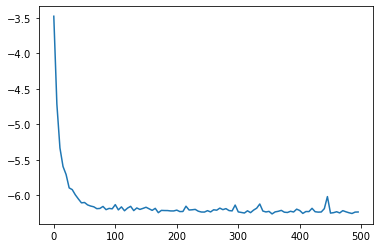

In [9]:
plt.plot(I,E)

In [92]:
i=0
while (vmc._samples[-i]==vmc._samples[-1]).all():
    i+=1
print(vmc._samples[-i], i)

[[1. 0. 1. 0. 1. 1.]
 [1. 0. 1. 0. 1. 1.]
 [1. 1. 1. 0. 1. 0.]
 [1. 0. 1. 0. 1. 1.]
 [1. 0. 1. 0. 1. 1.]
 [1. 1. 1. 0. 0. 1.]] 195
